In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, Normalizer

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima
import random
import itertools
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
import lightgbm as LGBMRegressor
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.decomposition import PCA, KernelPCA
from tqdm import tqdm
import itertools

In [2]:
train = pd.read_csv('./train.csv')
train

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
building = pd.read_csv('./building_info.csv')

# train["date"] = train["num_date_time"].apply(lambda x: x.split("_")[1])
# train["date"] = pd.to_datetime(train["date"])
# test["date"] = test["num_date_time"].apply(lambda x: x.split("_")[1])
# test["date"] = pd.to_datetime(test["date"])


train['month'] = train['일시'].apply(lambda x : float(x[4:6]))
train['day'] = train['일시'].apply(lambda x : float(x[6:8]))
train['time'] = train['일시'].apply(lambda x : float(x[9:11]))

test['month'] = test['일시'].apply(lambda x : float(x[4:6]))
test['day'] = test['일시'].apply(lambda x : float(x[6:8]))
test['time'] = test['일시'].apply(lambda x : float(x[9:11]))
train = train.drop(['num_date_time','강수량(mm)'],axis=1)
test = test.drop(['num_date_time','강수량(mm)'],axis=1)

train['일시'] = pd.to_datetime(train['일시'])
test['일시'] = pd.to_datetime(test['일시'])
train = train[train['일시'] > '2022-06-17T23:00:00.000000000']

train = train.drop(['일조(hr)','일사(MJ/m2)'],axis=1)

train['풍속(m/s)'] = np.log10(train['풍속(m/s)']+2)
test['풍속(m/s)'] = np.log10(test['풍속(m/s)']+2)

train = pd.merge(train,building)
test = pd.merge(test,building)
train = train.drop(['일시','태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'],axis=1)
test = test.drop(['일시','태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'],axis=1)


MM = MinMaxScaler()
train['습도(%)'] = MM.fit_transform(np.array(train['습도(%)']).reshape(-1,1))
test['습도(%)'] = MM.fit_transform(np.array(test['습도(%)']).reshape(-1,1))

enc = OneHotEncoder()
enc.fit(train[['건물유형']])
tp = pd.DataFrame(data=enc.transform(train[['건물유형']]).toarray(),columns=enc.categories_[0])
train = pd.concat([train,tp],axis=1)

enc = OneHotEncoder()
enc.fit(test[['건물유형']])
tp = pd.DataFrame(data=enc.transform(test[['건물유형']]).toarray(),columns=enc.categories_[0])
test = pd.concat([test,tp],axis=1)

MM = MinMaxScaler()
train['연면적(m2)'] = MM.fit_transform(np.array(train['냉방면적(m2)']).reshape(-1,1))
test['연면적(m2)'] = MM.fit_transform(np.array(test['냉방면적(m2)']).reshape(-1,1))
train['냉방면적(m2)'] = MM.fit_transform(np.array(train['냉방면적(m2)']).reshape(-1,1))
test['냉방면적(m2)'] = MM.fit_transform(np.array(test['냉방면적(m2)']).reshape(-1,1))

target = ['기온(C)','풍속(m/s)']
enc = Normalizer()
for tar in target:
    train[tar] = MM.fit_transform(np.array(train[tar]).reshape(-1,1))
    test[tar] = MM.fit_transform(np.array(test[tar]).reshape(-1,1))
    

enc = OneHotEncoder()
target = '건물번호'
enc.fit(train[[target]])
tp = pd.DataFrame(data=enc.transform(train[[target]]).toarray(),columns=[str(i) for i in enc.categories_[0]])
train = pd.concat([train,tp],axis=1)

enc = OneHotEncoder()
enc.fit(test[[target]])
tp = pd.DataFrame(data=enc.transform(test[[target]]).toarray(),columns=[str(i) for i in enc.categories_[0]])
test = pd.concat([test,tp],axis=1)

train = train.drop(['건물번호','건물유형'],axis=1)
test = test.drop(['건물번호','건물유형'],axis=1)

In [4]:
# kernel_pca = KernelPCA(
#     n_components=3
# )
# kernel_pca.fit(train[train['건물기타']==1][['기온(C)']])

In [5]:
def smape(A, F):
    return 100 / len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))


In [6]:
A = np.array([2,3,4,5,6,7,8,9]) # Actual
F = np.array([1,3,5,4,6,7,10,7]) # Forecast
smape(A,F)


9.895833333333334

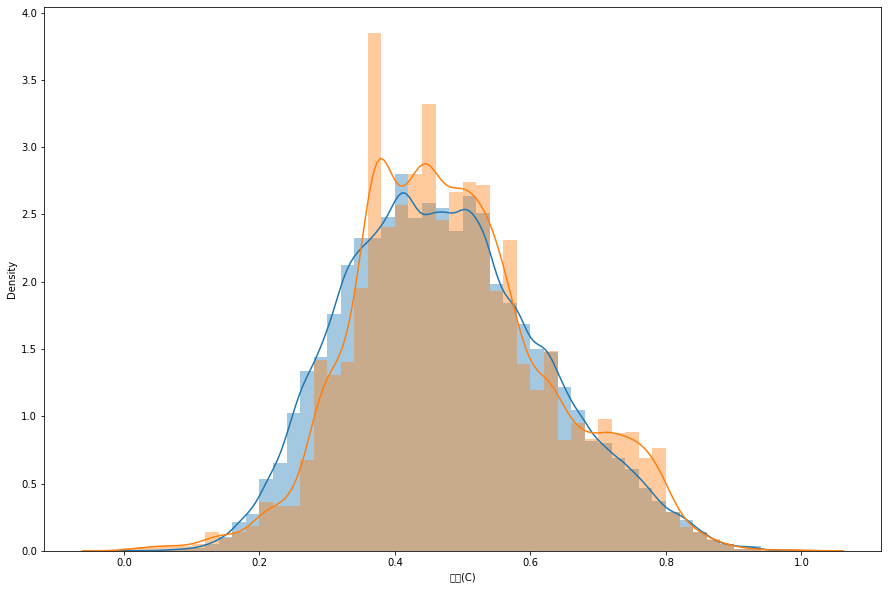

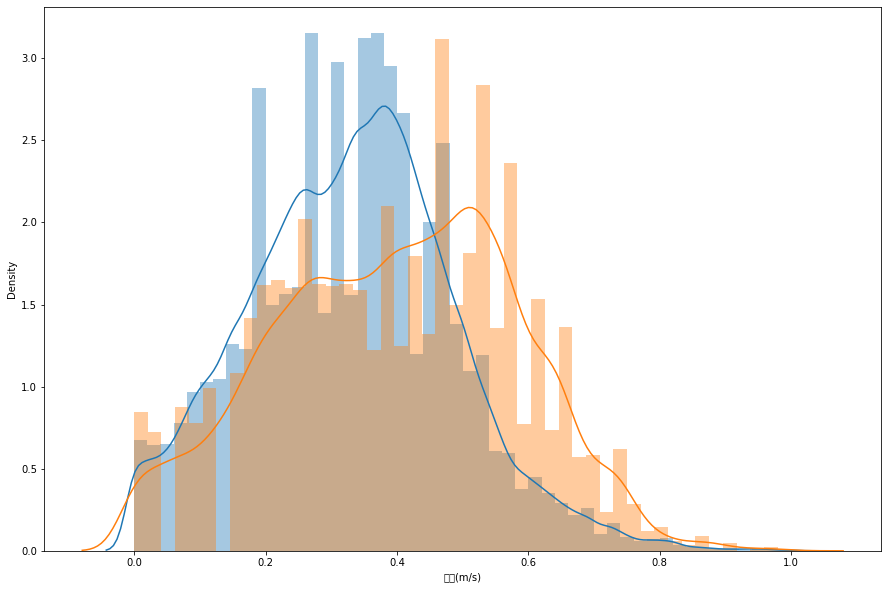

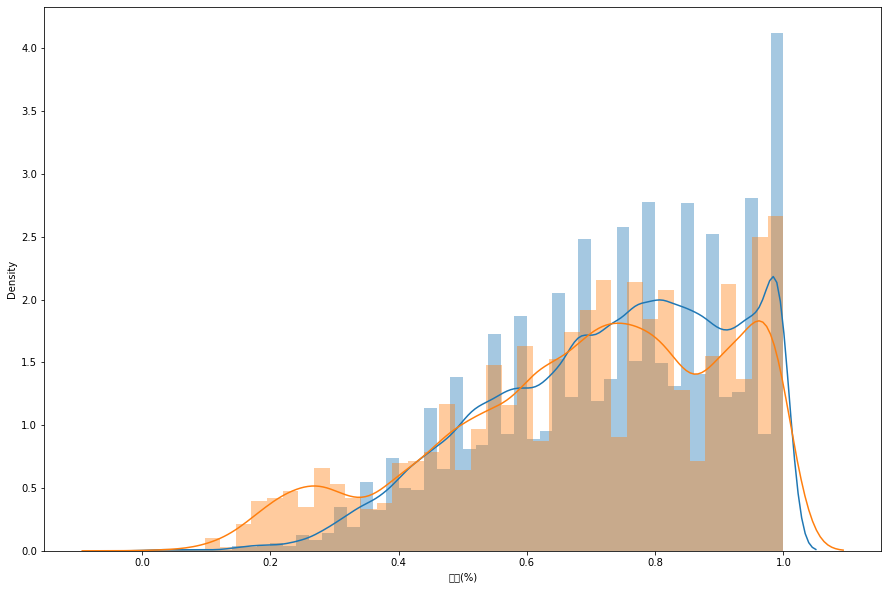

In [7]:
for i in ['기온(C)','풍속(m/s)','습도(%)']:
    plt.figure(figsize=(15,10))
    sns.distplot(train[i])
    sns.distplot(test[i])
    plt.show()

In [10]:
train.iloc[:,:21]

,기온(C),풍속(m/s),습도(%),전력소비량(kWh),month,day,time,연면적(m2),냉방면적(m2),건물기타,...,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트
0,0.281407,0.230993,0.757143,1236.96,6.0,18.0,0.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.271357,0.199275,0.785714,1163.52,6.0,18.0,1.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.256281,0.199275,0.785714,1070.88,6.0,18.0,2.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.256281,0.109669,0.771429,1048.80,6.0,18.0,3.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.261307,0.275035,0.771429,1087.68,6.0,18.0,4.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163195,0.296482,0.182613,0.800000,881.04,8.0,24.0,19.0,0.003659,0.003659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
163196,0.261307,0.246117,0.800000,798.96,8.0,24.0,20.0,0.003659,0.003659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
163197,0.206030,0.199275,0.885714,825.12,8.0,24.0,21.0,0.003659,0.003659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
163198,0.190955,0.068689,0.914286,640.08,8.0,24.0,22.0,0.003659,0.003659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
from pycaret import regression
regression.setup(data=train.iloc[:,:21],target='전력소비량(kWh)',create_date_columns=['month','day','time'] #  date_features=['일시']# 
                 ,fold_strategy='timeseries',train_size=0.9,session_id=77)
best = regression.compare_models(n_select=5)

,Description,Value
0,Session id,77
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(163200, 21)"
4,Transformed data shape,"(163200, 21)"
5,Transformed train set shape,"(146880, 21)"
6,Transformed test set shape,"(16320, 21)"
7,Numeric features,20
8,Rows with missing values,0.0%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,209.8683,196059.9855,439.1817,0.9689,0.1920,0.1138,9.4040
xgboost,Extreme Gradient Boosting,261.2866,198893.7859,445.2230,0.9684,0.2313,0.1536,2.9780
catboost,CatBoost Regressor,269.8176,202353.6340,449.0140,0.9679,0.2313,0.1593,4.6380
et,Extra Trees Regressor,222.5143,206014.0346,450.6908,0.9673,0.1998,0.1226,6.3890
lightgbm,Light Gradient Boosting Machine,334.9355,270773.8221,520.1849,0.9570,0.2624,0.2034,2.1770
dt,Decision Tree Regressor,240.8142,354764.9824,591.5908,0.9438,0.2513,0.1274,2.2950
gbr,Gradient Boosting Regressor,596.3909,680714.6346,825.0012,0.8918,0.3983,0.3666,2.8230
ada,AdaBoost Regressor,1229.1206,2059207.4458,1434.2623,0.6725,0.7542,1.0190,2.4520
lar,Least Angle Regression,1292.6542,4430965.3250,2104.5354,0.2963,0.6521,0.7237,1.8020
br,Bayesian Ridge,1292.6029,4430997.4000,2104.5430,0.2963,0.6520,0.7238,1.8680


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [13]:
sub = pd.read_csv('./sample_submission.csv')
sub['answer'] = np.array([i.predict(test.iloc[:,:20]) for i in best[:4]]).mean(0)
sub = sub.set_index('num_date_time')
sub.to_csv('./submission.csv')